# DeFi Wallet Credit Score Classification

This notebook develops a machine learning model to assign credit scores (0-1000) to wallets based on their transaction behavior with the Aave V2 protocol.

In [1]:
# Python Library
import numpy as np # For Matrix operation
import pandas as pd # load data
import matplotlib.pyplot as plt # Data Visualization
import seaborn as sns
import json # loading json data
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
warnings.filterwarnings('ignore')

# load json file
def load_data(file):
    with open(file, 'r') as f:
        data = json.load(f)
    return pd.DataFrame(data)

In [2]:
json_data = load_data('dataset/user-wallet-transactions.json') # load data and store into the variable

In [3]:
json_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   _id          100000 non-null  object
 1   userWallet   100000 non-null  object
 2   network      100000 non-null  object
 3   protocol     100000 non-null  object
 4   txHash       100000 non-null  object
 5   logId        100000 non-null  object
 6   timestamp    100000 non-null  int64 
 7   blockNumber  100000 non-null  int64 
 8   action       100000 non-null  object
 9   actionData   100000 non-null  object
 10  __v          100000 non-null  int64 
 11  createdAt    100000 non-null  object
 12  updatedAt    100000 non-null  object
dtypes: int64(3), object(10)
memory usage: 9.9+ MB


In [ ]:
json_data.describe

<bound method NDFrame.describe of                                         _id  \
0      {'$oid': '681d38fed63812d4655f571a'}   
1      {'$oid': '681aa70dd6df53021cc6f3c0'}   
2      {'$oid': '681d04c2d63812d4654c733e'}   
3      {'$oid': '681d133bd63812d46551b6ef'}   
4      {'$oid': '681899e4ba49fc91cf2f4454'}   
...                                     ...   
99995  {'$oid': '681c85447b724ae36a6df5c9'}   
99996  {'$oid': '681c8d5b7b724ae36a70c446'}   
99997  {'$oid': '681c8d5b7b724ae36a70c62f'}   
99998  {'$oid': '681c8d5b7b724ae36a70c752'}   
99999  {'$oid': '681c9855d63812d4652821e8'}   

                                       userWallet  network protocol  \
0      0x00000000001accfa9cef68cf5371a23025b6d4b6  polygon  aave_v2   
1      0x000000000051d07a4fb3bd10121a343d85818da6  polygon  aave_v2   
2      0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
3      0x000000000096026fb41fc39f9875d164bd82e2dc  polygon  aave_v2   
4      0x0000000000e189dd664b9ab08a33c48399538

In [5]:
json_data.columns

Index(['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId',
       'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt',
       'updatedAt'],
      dtype='object')

In [ ]:
json_data.head()

,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


In [7]:
# Function to process date dictionaries
def structure_datetime(date_dict):
    timestamp_str = date_dict['$date']
    created_at = datetime.fromisoformat(timestamp_str.replace('Z', '+00:00'))  # Ensures timezone compatibility
    return created_at

# Create a new column with formatted dates
json_data['createdAt'] = json_data['createdAt'].apply(structure_datetime)
json_data['updatedAt'] = json_data['updatedAt'].apply(structure_datetime)

In [8]:
json_data

,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,2025-05-08 23:06:39.465000+00:00,2025-05-08 23:06:39.465000+00:00
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,2025-05-07 00:19:26.159000+00:00,2025-05-07 00:19:26.159000+00:00
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,2025-05-08 19:23:47.877000+00:00,2025-05-08 19:23:47.877000+00:00
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,2025-05-08 20:25:33.141000+00:00,2025-05-08 20:25:33.141000+00:00
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,2025-05-05 10:58:45.934000+00:00,2025-05-05 10:58:45.934000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,{'$oid': '681c85447b724ae36a6df5c9'},0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,polygon,aave_v2,0x7c94fbaff37d45ed220e4eeac4e7f14f3476af596d12...,0x7c94fbaff37d45ed220e4eeac4e7f14f3476af596d12...,1623421245,1623421245,repay,"{'type': 'Repay', 'amount': '19724448273', 'as...",0,2025-05-08 10:19:50.145000+00:00,2025-05-08 10:19:50.145000+00:00
99996,{'$oid': '681c8d5b7b724ae36a70c446'},0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,polygon,aave_v2,0x04046c738ffa8a64323e0b8cb4b7a97883c722728e98...,0x04046c738ffa8a64323e0b8cb4b7a97883c722728e98...,1623558779,1623558779,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '200000...",0,2025-05-08 10:54:21.390000+00:00,2025-05-08 10:54:21.390000+00:00
99997,{'$oid': '681c8d5b7b724ae36a70c62f'},0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,polygon,aave_v2,0x77eab9a16e1b49a53365882b82786cf86263e73b358e...,0x77eab9a16e1b49a53365882b82786cf86263e73b358e...,1623559191,1623559191,deposit,"{'type': 'Deposit', 'amount': '199401391185794...",0,2025-05-08 10:54:21.403000+00:00,2025-05-08 10:54:21.403000+00:00
99998,{'$oid': '681c8d5b7b724ae36a70c752'},0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,polygon,aave_v2,0xf170ce9fed71fa7b8221f08fe8a601c5bf84b6f8e724...,0xf170ce9fed71fa7b8221f08fe8a601c5bf84b6f8e724...,1623559417,1623559417,borrow,"{'type': 'Borrow', 'amount': '4000000000', 'as...",0,2025-05-08 10:54:21.411000+00:00,2025-05-08 10:54:21.411000+00:00


In [9]:
def correct_id(path):
    return path['$oid']

In [10]:
json_data['_id'] = json_data['_id'].apply(correct_id)

In [11]:
json_data['actionData'][0]

{'type': 'Deposit',
 'amount': '2000000000',
 'assetSymbol': 'USDC',
 'assetPriceUSD': '0.9938318274296357543568636362026045',
 'poolId': '0x2791bca1f2de4661ed88a30c99a7a9449aa84174',
 'userId': '0x00000000001accfa9cef68cf5371a23025b6d4b6'}

In [12]:
def extract_relevant_fields(data):
    required_keys = ['amount', 'assetSymbol', 'assetPriceUSD', 'poolId']
    return {key: data[key] for key in required_keys if key in data}

In [13]:
sample = pd.DataFrame(json_data['actionData'].apply(extract_relevant_fields))

In [14]:
sample['actionData'][0]

{'amount': '2000000000',
 'assetSymbol': 'USDC',
 'assetPriceUSD': '0.9938318274296357543568636362026045',
 'poolId': '0x2791bca1f2de4661ed88a30c99a7a9449aa84174'}

In [15]:
# Step 1: Extract relevant fields into a new DataFrame
extracted_df = json_data['actionData'].apply(extract_relevant_fields).apply(pd.Series)

# Step 2: Combine with original json_data (keeping all columns)
final_df = pd.concat([json_data, extracted_df], axis=1)


In [16]:
final_df.columns

Index(['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId',
       'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt',
       'updatedAt', 'amount', 'assetSymbol', 'assetPriceUSD', 'poolId'],
      dtype='object')

In [ ]:
df = final_df.drop(columns=['_id', '__v', 'createdAt', 'updatedAt', 'txHash', 'logId', 'actionData'])
df.head()

,userWallet,network,protocol,timestamp,blockNumber,action,amount,assetSymbol,assetPriceUSD,poolId
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,1629178166,1629178166,deposit,2000000000,USDC,0.9938318274296357543568636362026045,0x2791bca1f2de4661ed88a30c99a7a9449aa84174
1,0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,1621525013,1621525013,deposit,145000000000000000000,WMATIC,1.970306761113742502077627085754506,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270
2,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,1627118913,1627118913,deposit,1000000000000000,WMATIC,0.9223772540040778087468127454060907,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270
3,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,1627773318,1627773318,deposit,4000000000000000,WMATIC,1.057483342538527030870377652200841,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270
4,0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,1618845907,1618845907,redeemunderlying,501548,USDC,1.00212969929885247748335868168494,0x2791bca1f2de4661ed88a30c99a7a9449aa84174


In [ ]:
df.head()

,userWallet,network,protocol,timestamp,blockNumber,action,amount,assetSymbol,assetPriceUSD,poolId
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,1629178166,1629178166,deposit,2000000000,USDC,0.9938318274296357543568636362026045,0x2791bca1f2de4661ed88a30c99a7a9449aa84174
1,0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,1621525013,1621525013,deposit,145000000000000000000,WMATIC,1.970306761113742502077627085754506,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270
2,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,1627118913,1627118913,deposit,1000000000000000,WMATIC,0.9223772540040778087468127454060907,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270
3,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,1627773318,1627773318,deposit,4000000000000000,WMATIC,1.057483342538527030870377652200841,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270
4,0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,1618845907,1618845907,redeemunderlying,501548,USDC,1.00212969929885247748335868168494,0x2791bca1f2de4661ed88a30c99a7a9449aa84174


In [19]:
df.isnull().sum()

userWallet       0
network          0
protocol         0
timestamp        0
blockNumber      0
action           0
amount           0
assetSymbol      0
assetPriceUSD    0
poolId           0
dtype: int64

In [20]:
df['action'].unique()

array(['deposit', 'redeemunderlying', 'borrow', 'repay',
       'liquidationcall'], dtype=object)

In [21]:
df.head()

,userWallet,network,protocol,timestamp,blockNumber,action,amount,assetSymbol,assetPriceUSD,poolId
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,1629178166,1629178166,deposit,2000000000,USDC,0.9938318274296357543568636362026045,0x2791bca1f2de4661ed88a30c99a7a9449aa84174
1,0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,1621525013,1621525013,deposit,145000000000000000000,WMATIC,1.970306761113742502077627085754506,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270
2,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,1627118913,1627118913,deposit,1000000000000000,WMATIC,0.9223772540040778087468127454060907,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270
3,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,1627773318,1627773318,deposit,4000000000000000,WMATIC,1.057483342538527030870377652200841,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270
4,0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,1618845907,1618845907,redeemunderlying,501548,USDC,1.00212969929885247748335868168494,0x2791bca1f2de4661ed88a30c99a7a9449aa84174


In [22]:
df['network'].unique()

array(['polygon'], dtype=object)

In [23]:
df['action'].unique()

array(['deposit', 'redeemunderlying', 'borrow', 'repay',
       'liquidationcall'], dtype=object)

In [24]:
df['amount'].unique()

array(['2000000000', '145000000000000000000', '1000000000000000', ...,
       '10003361154', '19724448273', '1994013911857945550'], dtype=object)

In [25]:
import pandas as pd

# Ensure 'amount' is treated as numeric
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')

# Define a sensible threshold — tweak as needed
max_reasonable_value = 1e12  # for example: one trillion

# Filter out values above threshold or NaN
df_cleaned = df[df['amount'] < max_reasonable_value].dropna(subset=['amount'])

# Optional: Reset index for neatness
df_cleaned = df_cleaned.reset_index(drop=True)

In [27]:
def assign_credit_score(row):
    try:
        amt = float(row['amount'])
    except (ValueError, TypeError):
        amt = 0
    
    if row['action'] == 'deposit':
        return 4 if amt > 1e20 else 3  # Excellent or Good
    elif row['action'] == 'redeemunderlying':
        return 3  # Good
    elif row['action'] == 'borrow':
        return 1  # Low (was -1)
    elif row['action'] == 'repay':
        return 3  # Good
    elif row['action'] == 'liquidationcall':
        return 0  # Very Low (was -2)
    else:
        return 2  # Medium (default)

df['creditScore'] = df.apply(assign_credit_score, axis=1)

In [28]:
df['creditScore'].unique()

array([3, 4, 1, 0])

In [29]:
df.head()

,userWallet,network,protocol,timestamp,blockNumber,action,amount,assetSymbol,assetPriceUSD,poolId,creditScore
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,1629178166,1629178166,deposit,2.000000e+09,USDC,0.9938318274296357543568636362026045,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,3
1,0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,1621525013,1621525013,deposit,1.450000e+20,WMATIC,1.970306761113742502077627085754506,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,4
2,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,1627118913,1627118913,deposit,1.000000e+15,WMATIC,0.9223772540040778087468127454060907,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,3
3,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,1627773318,1627773318,deposit,4.000000e+15,WMATIC,1.057483342538527030870377652200841,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,3
4,0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,1618845907,1618845907,redeemunderlying,5.015480e+05,USDC,1.00212969929885247748335868168494,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,3


In [30]:
df['creditScore'].value_counts()

creditScore
3    74934
1    17086
4     7732
0      248
Name: count, dtype: int64

In [31]:
df['action'].unique()

array(['deposit', 'redeemunderlying', 'borrow', 'repay',
       'liquidationcall'], dtype=object)

In [32]:
# df['action'] = df['action'].map({'borrow': 0, 'deposit': 1, 'redeemunderlying': 2, 'liquidationcall': 3, 'repay': 4})

In [33]:
df.columns

Index(['userWallet', 'network', 'protocol', 'timestamp', 'blockNumber',
       'action', 'amount', 'assetSymbol', 'assetPriceUSD', 'poolId',
       'creditScore'],
      dtype='object')

In [34]:
df['creditScore'].unique()

array([3, 4, 1, 0])

In [35]:
df['action'].unique()

array(['deposit', 'redeemunderlying', 'borrow', 'repay',
       'liquidationcall'], dtype=object)

In [36]:
df['action'].isnull().sum()

np.int64(0)

In [37]:
df['action'].isnull().sum()

np.int64(0)

In [38]:
df

,userWallet,network,protocol,timestamp,blockNumber,action,amount,assetSymbol,assetPriceUSD,poolId,creditScore
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,1629178166,1629178166,deposit,2.000000e+09,USDC,0.9938318274296357543568636362026045,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,3
1,0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,1621525013,1621525013,deposit,1.450000e+20,WMATIC,1.970306761113742502077627085754506,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,4
2,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,1627118913,1627118913,deposit,1.000000e+15,WMATIC,0.9223772540040778087468127454060907,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,3
3,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,1627773318,1627773318,deposit,4.000000e+15,WMATIC,1.057483342538527030870377652200841,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270,3
4,0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,1618845907,1618845907,redeemunderlying,5.015480e+05,USDC,1.00212969929885247748335868168494,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,3
...,...,...,...,...,...,...,...,...,...,...,...
99995,0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,polygon,aave_v2,1623421245,1623421245,repay,1.972445e+10,USDT,1.002190552454766597115369809173134,0xc2132d05d31c914a87c6611c10748aeb04b58e8f,3
99996,0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,polygon,aave_v2,1623558779,1623558779,redeemunderlying,2.000000e+18,WETH,2342.039086000003558177674738167022,0x7ceb23fd6bc0add59e62ac25578270cff1b9f619,3
99997,0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,polygon,aave_v2,1623559191,1623559191,deposit,1.994014e+18,WETH,2342.039086000003558177674738167022,0x7ceb23fd6bc0add59e62ac25578270cff1b9f619,3
99998,0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,polygon,aave_v2,1623559417,1623559417,borrow,4.000000e+09,USDC,1.00190090059994152215282747624047,0x2791bca1f2de4661ed88a30c99a7a9449aa84174,1


In [39]:
X = df.drop(columns=['creditScore'])

In [40]:
X

,userWallet,network,protocol,timestamp,blockNumber,action,amount,assetSymbol,assetPriceUSD,poolId
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,1629178166,1629178166,deposit,2.000000e+09,USDC,0.9938318274296357543568636362026045,0x2791bca1f2de4661ed88a30c99a7a9449aa84174
1,0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,1621525013,1621525013,deposit,1.450000e+20,WMATIC,1.970306761113742502077627085754506,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270
2,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,1627118913,1627118913,deposit,1.000000e+15,WMATIC,0.9223772540040778087468127454060907,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270
3,0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,1627773318,1627773318,deposit,4.000000e+15,WMATIC,1.057483342538527030870377652200841,0x0d500b1d8e8ef31e21c99d1db9a6444d3adf1270
4,0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,1618845907,1618845907,redeemunderlying,5.015480e+05,USDC,1.00212969929885247748335868168494,0x2791bca1f2de4661ed88a30c99a7a9449aa84174
...,...,...,...,...,...,...,...,...,...,...
99995,0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,polygon,aave_v2,1623421245,1623421245,repay,1.972445e+10,USDT,1.002190552454766597115369809173134,0xc2132d05d31c914a87c6611c10748aeb04b58e8f
99996,0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,polygon,aave_v2,1623558779,1623558779,redeemunderlying,2.000000e+18,WETH,2342.039086000003558177674738167022,0x7ceb23fd6bc0add59e62ac25578270cff1b9f619
99997,0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,polygon,aave_v2,1623559191,1623559191,deposit,1.994014e+18,WETH,2342.039086000003558177674738167022,0x7ceb23fd6bc0add59e62ac25578270cff1b9f619
99998,0x06192f889f17bf2aff238d08d8c26cbcfcc7b45a,polygon,aave_v2,1623559417,1623559417,borrow,4.000000e+09,USDC,1.00190090059994152215282747624047,0x2791bca1f2de4661ed88a30c99a7a9449aa84174


In [41]:
X.columns

Index(['userWallet', 'network', 'protocol', 'timestamp', 'blockNumber',
       'action', 'amount', 'assetSymbol', 'assetPriceUSD', 'poolId'],
      dtype='object')

In [42]:
X = X.drop(columns=['userWallet', 'blockNumber', 'poolId'])
X = X.drop(columns=['network', 'protocol'], axis=1)

In [43]:
X['action'].unique()

array(['deposit', 'redeemunderlying', 'borrow', 'repay',
       'liquidationcall'], dtype=object)

In [44]:
X

,timestamp,action,amount,assetSymbol,assetPriceUSD
0,1629178166,deposit,2.000000e+09,USDC,0.9938318274296357543568636362026045
1,1621525013,deposit,1.450000e+20,WMATIC,1.970306761113742502077627085754506
2,1627118913,deposit,1.000000e+15,WMATIC,0.9223772540040778087468127454060907
3,1627773318,deposit,4.000000e+15,WMATIC,1.057483342538527030870377652200841
4,1618845907,redeemunderlying,5.015480e+05,USDC,1.00212969929885247748335868168494
...,...,...,...,...,...
99995,1623421245,repay,1.972445e+10,USDT,1.002190552454766597115369809173134
99996,1623558779,redeemunderlying,2.000000e+18,WETH,2342.039086000003558177674738167022
99997,1623559191,deposit,1.994014e+18,WETH,2342.039086000003558177674738167022
99998,1623559417,borrow,4.000000e+09,USDC,1.00190090059994152215282747624047


In [45]:
X['assetSymbol'].unique()

array(['USDC', 'WMATIC', 'DAI', 'WBTC', 'WETH', 'USDT', 'WPOL', 'AAVE',
       ''], dtype=object)

In [46]:
X['action'].unique()

array(['deposit', 'redeemunderlying', 'borrow', 'repay',
       'liquidationcall'], dtype=object)

In [47]:
X['assetSymbol'] = X['assetSymbol'].map({'USDC': 1, 'WMATIC':2, 'DAI':3, 'WBTC':4, 'WETH':5, 'USDT':6, 'WPOL':7, 'AAVE':8,'':0})

In [48]:
X['action'] = X['action'].map({'borrow': 0, 'deposit': 1, 'redeemunderlying': 2, 'liquidationcall': 3, 'repay': 4})

In [49]:
Y = df['creditScore']
Y

0        3
1        4
2        3
3        3
4        3
        ..
99995    3
99996    3
99997    3
99998    1
99999    1
Name: creditScore, Length: 100000, dtype: int64

In [50]:
# X = np.array(X)
# Y = np.array(Y)

In [51]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Scale features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Now X.shape[1] is defined (should be 9)
# model = MyModel(n_features=X.shape[1])

In [52]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

x_train.shape, x_test.shape, x_val.shape

((70000, 5), (15000, 5), (15000, 5))

In [53]:
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

class dataset(Dataset):
    def __init__(self, X, Y):
    # Ensure numeric
        X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
        Y = Y.apply(pd.to_numeric, errors='coerce').fillna(0)

        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        self.Y = torch.tensor(Y.to_numpy(), dtype=torch.long)  # Not float32


    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [54]:
import torch
tranning_data = dataset(x_train, y_train)
Validation_data = dataset(x_val, y_val)
test_data = dataset(x_test, y_test)

In [55]:
train_dataloader = DataLoader(tranning_data, batch_size=8,shuffle=True)
val_dataloader = DataLoader(Validation_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=True, batch_size=8)

In [56]:
for x, y in train_dataloader:
    print(x)
    print('--------')
    print(y)
    break

tensor([[1.6210e+09, 1.0000e+00, 1.5000e+19, 7.0000e+00, 1.6213e+00],
        [1.6236e+09, 2.0000e+00, 1.5310e+10, 1.0000e+00, 1.0016e+00],
        [1.6228e+09, 2.0000e+00, 4.0934e+19, 3.0000e+00, 1.0034e+00],
        [1.6238e+09, 0.0000e+00, 1.5000e+09, 1.0000e+00, 1.0041e+00],
        [1.6293e+09, 1.0000e+00, 1.1600e+20, 7.0000e+00, 1.3313e+00],
        [1.6287e+09, 0.0000e+00, 1.6000e+07, 1.0000e+00, 9.7495e-01],
        [1.6293e+09, 4.0000e+00, 5.0012e+16, 5.0000e+00, 3.0136e+03],
        [1.6221e+09, 2.0000e+00, 1.5376e+20, 3.0000e+00, 1.0041e+00]])
--------
tensor([3, 3, 3, 1, 4, 1, 3, 3])


In [57]:
import torch
import torch.nn as nn

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Pass input size dynamically
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_neurons=30):
        super(MyModel, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_neurons)
        self.linear = nn.Linear(hidden_neurons, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

# Initialize model AFTER you know input feature size
input_size = x_train.shape[1]  # assuming x_train is a DataFrame
model = MyModel(input_size).to(device)  # Move model to GPU


Using device: cuda


In [58]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 30]             180
            Linear-2                    [-1, 1]              31
           Sigmoid-3                    [-1, 1]               0
Total params: 211
Trainable params: 211
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [59]:
import torch
import torch.nn as nn
from torch.optim import Adam

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # Instead of MSE or BCE
optimizer = Adam(model.parameters(), lr=1e-3)

# Plots
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

# Training Loop
for epoch in range(10):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    total_samples_train = 0
    total_samples_val = 0

    # --- TRAINING ---
    model.train()
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Clean labels: convert to float and make sure they are 0. or 1.
        labels = labels.float()
        labels = torch.clamp(labels, 0, 1)

        # Forward
        outputs = model(inputs).squeeze(1)  # shape: (batch_size,)
        loss = criterion(outputs, labels)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()
        total_acc_train += (outputs.round() == labels).sum().item()
        total_samples_train += labels.size(0)

    # --- VALIDATION ---
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            labels = labels.float()
            labels = torch.clamp(labels, 0, 1)

            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)

            total_loss_val += loss.item()
            total_acc_val += (outputs.round() == labels).sum().item()
            total_samples_val += labels.size(0)

    # --- METRICS ---
    avg_train_loss = total_loss_train / len(train_dataloader)
    avg_val_loss = total_loss_val / len(val_dataloader)
    train_accuracy = total_acc_train / total_samples_train * 100
    val_accuracy = total_acc_val / total_samples_val * 100

    # --- STORE ---
    total_loss_train_plot.append(round(avg_train_loss, 4))
    total_loss_val_plot.append(round(avg_val_loss, 4))
    total_acc_train_plot.append(round(train_accuracy, 4))
    total_acc_val_plot.append(round(val_accuracy, 4))

    print(f"Epoch {epoch+1}: "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")
    print("=" * 50)


Using device: cuda
Epoch 1: Train Loss: 16.5925 | Train Acc: 99.74% | Val Loss: 16.6045 | Val Acc: 99.81%
Epoch 2: Train Loss: 16.5925 | Train Acc: 99.74% | Val Loss: 16.6045 | Val Acc: 99.81%
Epoch 3: Train Loss: 16.5925 | Train Acc: 99.74% | Val Loss: 16.6045 | Val Acc: 99.81%
Epoch 4: Train Loss: 16.5925 | Train Acc: 99.74% | Val Loss: 16.6045 | Val Acc: 99.81%
Epoch 5: Train Loss: 16.5925 | Train Acc: 99.74% | Val Loss: 16.6045 | Val Acc: 99.81%
Epoch 6: Train Loss: 16.5925 | Train Acc: 99.74% | Val Loss: 16.6045 | Val Acc: 99.81%
Epoch 7: Train Loss: 16.5925 | Train Acc: 99.74% | Val Loss: 16.6045 | Val Acc: 99.81%
Epoch 8: Train Loss: 16.5925 | Train Acc: 99.74% | Val Loss: 16.6045 | Val Acc: 99.81%
Epoch 9: Train Loss: 16.5925 | Train Acc: 99.74% | Val Loss: 16.6045 | Val Acc: 99.81%
Epoch 10: Train Loss: 16.5925 | Train Acc: 99.74% | Val Loss: 16.6045 | Val Acc: 99.81%


In [61]:
model.eval()
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    total_samples_test = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.float().to(device)       # Ensure correct dtype and device
        labels = labels.float().to(device)       # For BCELoss, labels must be float
        labels = torch.clamp(labels, 0, 1)       # Ensure binary

        prediction = model(inputs).squeeze(1)    # shape: (batch_size,)
        batch_loss = criterion(prediction, labels)
        total_loss_test += batch_loss.item()

        acc = (prediction.round() == labels).sum().item()
        total_acc_test += acc
        total_samples_test += labels.size(0)

# Final accuracy
print('Accuracy on test set: {:.2f}%'.format(total_acc_test / total_samples_test * 100))


Accuracy on test set: 99.74%


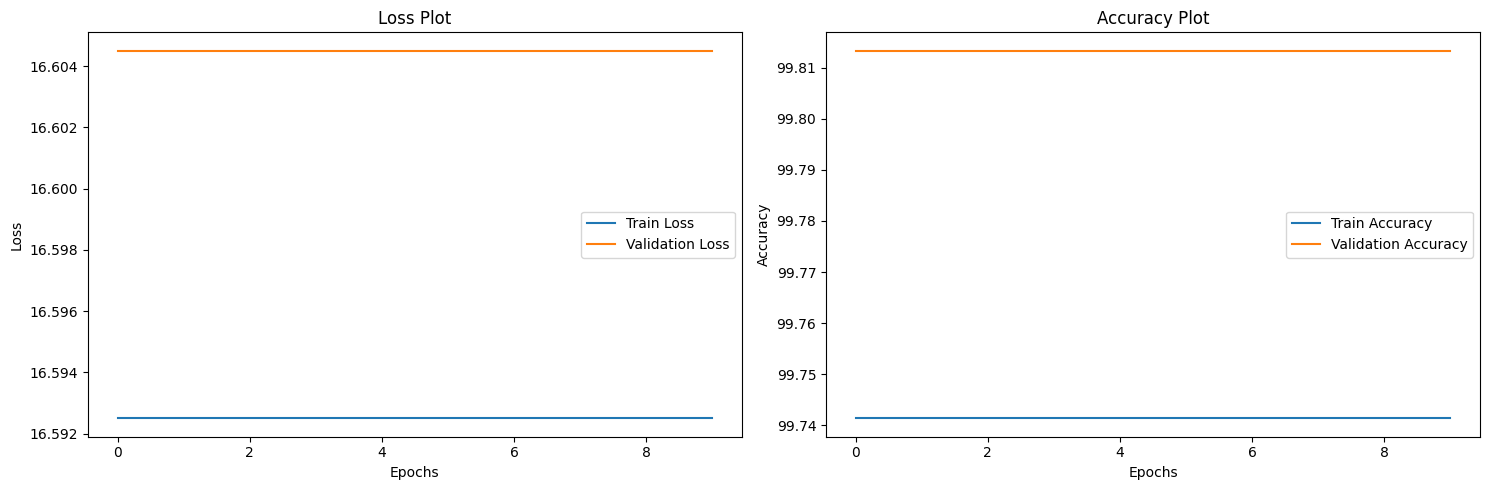

In [62]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axs[0].plot(total_loss_train_plot, label='Train Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')

axs[0].set_title('Loss Plot')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].plot(total_acc_train_plot, label='Train Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Accuracy Plot')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
plt.tight_layout()
plt.show()

In [68]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

# ─── 0. (Optional) Synchronize CUDA errors for debugging ───────────────────────
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# ─── 1. Device ─────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ─── 2. Dataset + DataLoader ───────────────────────────────────────────────────
class TabularDataset(Dataset):
    def __init__(self, X_df: pd.DataFrame, y_df: pd.DataFrame):
        # convert DataFrame ➔ NumPy array of floats ➔ Torch tensor
        X = X_df.to_numpy().astype(np.float32)
        y = y_df.to_numpy().astype(np.float32)
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# replace these with your DataFrames
# x_train, y_train, x_val, y_val, x_test, y_test = ...

train_ds = TabularDataset(x_train, y_train)
val_ds   = TabularDataset(x_val,   y_val)
test_ds  = TabularDataset(x_test,  y_test)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

# ─── 3. Model definition ────────────────────────────────────────────────────────
HIDDEN_NEURONS = 30

class MyModel(nn.Module):
    def __init__(self, input_size, hidden_neurons=HIDDEN_NEURONS):
        super().__init__()
        self.input_layer = nn.Linear(input_size, hidden_neurons)
        self.linear      = nn.Linear(hidden_neurons, 1)
        self.sigmoid     = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        return self.sigmoid(x)

input_size = x_train.shape[1]
model = MyModel(input_size).to(device)

# ─── 4. Loss & optimizer ───────────────────────────────────────────────────────
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3)

# ─── 5. Training + Validation loop ─────────────────────────────────────────────
num_epochs = 10

# for plotting if you like
train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

for epoch in range(1, num_epochs + 1):
    # ---- TRAIN ----
    model.train()
    running_loss, running_acc, running_samples = 0., 0., 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device).float().clamp(0,1)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)         # shape: [batch_size]
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss    += loss.item()
        running_acc     += (outputs.round() == labels).sum().item()
        running_samples += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_acc_pct  = running_acc    / running_samples * 100

    # ---- VALIDATE ----
    model.eval()
    val_loss, val_acc, val_samples = 0., 0., 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).float().clamp(0,1)

            outputs = model(inputs).squeeze(1)
            loss    = criterion(outputs, labels)

            val_loss    += loss.item()
            val_acc     += (outputs.round() == labels).sum().item()
            val_samples += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc_pct  = val_acc    / val_samples * 100

    # store for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(train_acc_pct)
    val_accs.append(val_acc_pct)

    print(f"Epoch {epoch:2d} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc_pct:6.2f}% | "
          f"Val Loss:   {avg_val_loss:.4f} | Val Acc:   {val_acc_pct:6.2f}%")

# ─── 6. Test Loop ───────────────────────────────────────────────────────────────
model.eval()
test_loss, test_acc, test_samples = 0., 0., 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device).float()
        labels = labels.to(device).float().clamp(0,1)

        outputs = model(inputs).squeeze(1)
        loss    = criterion(outputs, labels)

        test_loss    += loss.item()
        test_acc     += (outputs.round() == labels).sum().item()
        test_samples += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_acc_pct  = test_acc    / test_samples * 100

print(f"\nTest Loss: {avg_test_loss:.4f} | Test Acc: {test_acc_pct:.2f}%")


Using device: cuda
Epoch  1 | Train Loss: 99.7410 | Train Acc:   0.26% | Val Loss:   99.8138 | Val Acc:     0.19%
Epoch  2 | Train Loss: 99.7415 | Train Acc:   0.26% | Val Loss:   99.8138 | Val Acc:     0.19%
Epoch  3 | Train Loss: 99.7415 | Train Acc:   0.26% | Val Loss:   99.8138 | Val Acc:     0.19%
Epoch  4 | Train Loss: 99.7415 | Train Acc:   0.26% | Val Loss:   99.8138 | Val Acc:     0.19%
Epoch  5 | Train Loss: 99.7415 | Train Acc:   0.26% | Val Loss:   99.8138 | Val Acc:     0.19%
Epoch  6 | Train Loss: 99.7415 | Train Acc:   0.26% | Val Loss:   99.8138 | Val Acc:     0.19%
Epoch  7 | Train Loss: 99.7415 | Train Acc:   0.26% | Val Loss:   99.8138 | Val Acc:     0.19%
Epoch  8 | Train Loss: 99.7415 | Train Acc:   0.26% | Val Loss:   99.8138 | Val Acc:     0.19%
Epoch  9 | Train Loss: 99.7415 | Train Acc:   0.26% | Val Loss:   99.8138 | Val Acc:     0.19%
Epoch 10 | Train Loss: 99.7415 | Train Acc:   0.26% | Val Loss:   99.8138 | Val Acc:     0.19%

Test Loss: 99.7407 | Test Acc: